In [1]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

# データの取得

In [2]:
train = pd.read_csv('titanic_train.csv')
test = pd.read_csv('titanic_test.csv')

# 前処理

In [3]:
full_data = [train, test]

In [4]:
for dataset in full_data:
    
    #AgeのNaNに平均値を中心とした標準正規分布する値を代入
    age_ave = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_ave-age_std, age_ave+age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
    #maleを1,femaleを0に変換
    dataset['Sex'] = dataset['Sex'].map({'male':1, 'female':0})
    
    #FareのNanに中央値を代入し、int型に変換
    dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median()).astype(int)
    
    #EmbarkedのNaNに最頻値を代入
    dataset['Embarked'] = dataset['Embarked'].fillna(statistics.mode(train['Embarked']))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
#indexをPassengerIdに変更
train = train.set_index('PassengerId')
test = test.set_index('PassengerId')

# 特徴量の作成

In [6]:
class Feature(object):
    def __init__(self, data):
        self.data = data
        
class Pclass(Feature):
    def extract(self):
        return pd.get_dummies(self.data['Pclass'], prefix='Pclass', prefix_sep='_')
    
class NameLength(Feature):
    def extract(self):
        return pd.DataFrame({'Name_Length':self.data['Name'].apply(len)}, index=self.data.index)
    
class Sex(Feature):
    def extract(self):
        return self.data[['Sex']]
    
class Age(Feature):
    def extract(self):
        return self.data[['Age']]
    
class SibSp(Feature):
    def extract(self):
        return self.data[['SibSp']]
    
class Parch(Feature):
    def extract(self):
        return self.data[['Parch']]
    
class Fare(Feature):
    def extract(self):
        return self.data[['Fare']]
    
class HasCabin(Feature):
    def extract(self):
        return pd.DataFrame({'Has_Cabin':self.data['Cabin'].apply(lambda x: 0 if type(x)==float else 1)},\
                            index=self.data.index)
    
class Embarked(Feature):
    def extract(self):
        return pd.get_dummies(self.data['Embarked'], prefix='Embarked', prefix_sep='_')

In [7]:
class Join(Feature):
    def extract(self, feature):
        feature = feature.join(Pclass(self.data).extract())
        feature = feature.join(NameLength(self.data).extract())
        feature = feature.join(Sex(self.data).extract())
        feature = feature.join(Age(self.data).extract())
        feature = feature.join(SibSp(self.data).extract())
        feature = feature.join(Parch(self.data).extract())
        feature = feature.join(Fare(self.data).extract())
        feature = feature.join(HasCabin(self.data).extract())
        feature = feature.join(Embarked(self.data).extract())
        return feature

In [8]:
#train用とtest用の特徴量を一つのDFとして作成
X = Join(train).extract(pd.DataFrame(index=train.index))
X_test = Join(test).extract(pd.DataFrame(index=test.index))

# データの可視化

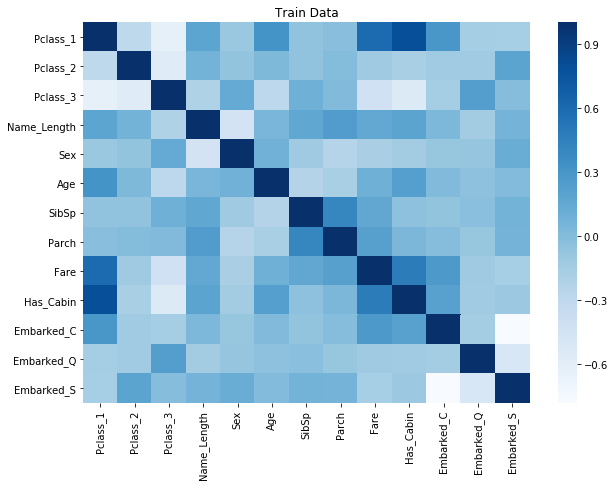

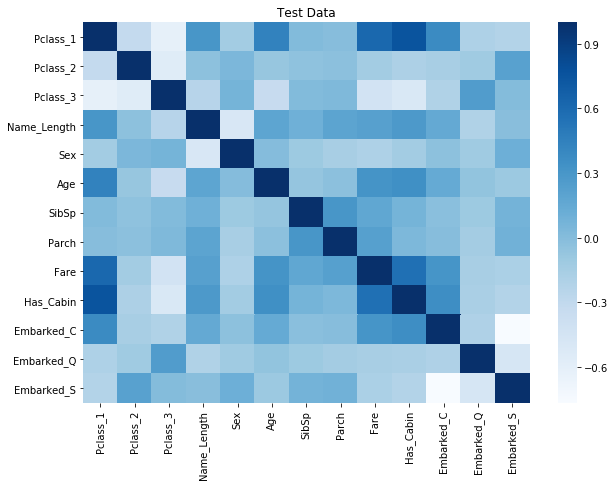

In [9]:
plt.figure(figsize=(10,7))
sns.heatmap(X.corr(), annot=False, cmap='Blues')
plt.title('Train Data')
plt.show()
plt.figure(figsize=(10,7))
sns.heatmap(X_test.corr(), annot=False, cmap='Blues')
plt.title('Test Data')
plt.show()

# モデル学習

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [13]:
#モデルの定義
nor = Normalizer()
std = StandardScaler()
lr = LinearRegression()
rid = Ridge()
pl = Pipeline(steps=[('std', std), ('lr', lr)])

#目的変数としてSurvivedのcolumnを定義
y = train['Survived']

#trainを学習用とモデル評価用に分割
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=1)

#モデルを学習
pl.fit(X_train, y_train)

#学習モデルによる評価データの予測
pre_val = [0 if number<0.5 else 1 for number in pl.predict(X_val).flatten()]

#学習モデルの評価
print('学習モデルの評価：',pl.score(X_train, y_train))

#予測データの評価(roc_auc_score)
print('roc_auc_score：',roc_auc_score(y_val, pre_val))

#予測データの評価(accuracy)
print('     accuracy：',accuracy_score(y_val, pre_val))

学習モデルの評価： 0.424170284969
roc_auc_score： 0.792258981649
     accuracy： 0.804469273743


/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


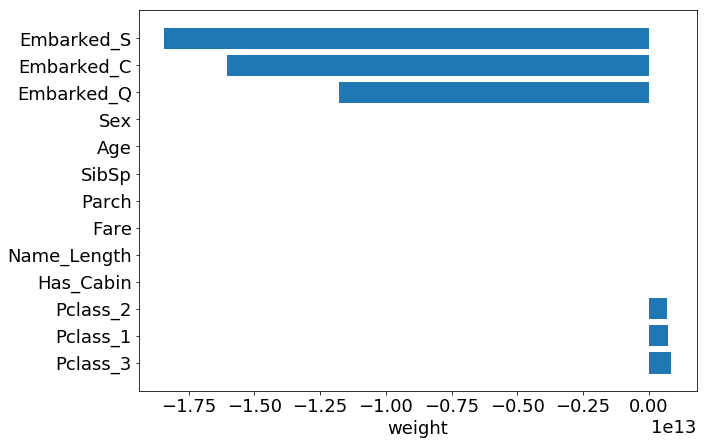

In [19]:
coef = sorted(dict(zip(X_val.columns, lr.coef_)).items(), key=lambda x: -x[1])
x_values = np.linspace(1, len(coef), len(coef))
x_name = [coef_i[0] for coef_i in coef]
y_values = [coef_i[1] for coef_i in coef]
plt.figure(figsize=(10,7))
plt.rcParams['font.size'] = 18
plt.barh(x_values, y_values)
plt.xlabel('weight')
plt.yticks(x_values, x_name)
plt.show()

# ファイル作成

In [105]:
#学習モデルによるテストデータの予測
predictions = [0 if number<0.5 else 1 for number in pl.predict(X_test).flatten()]

#CSVファイルを作成
submission = pd.DataFrame({'PassengerId':X_test.index.values, 'Survived':predictions})
submission.to_csv('titanic_submission.csv', index=False)